In [1]:
import requests
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt

In [7]:
# Dados do serviço WMS
WMS_URL = "http://mapsref.brgm.fr/wxs/1GG/CGMW_Bedrock_and_Structural_Geology"
LAYERS = "World_CGMW_50M_GeologicalUnitsOnshore"
CRS = "EPSG:4326"
VERSION = "1.3.0"  # Versão do WMS

# Coordenadas de interesse (Exemplo: São Paulo)
latitude = -23.5505
longitude = -46.6333

# Tamanho da imagem (em pixels)
WIDTH = 100
HEIGHT = 100

# Definir a extensão (bounding box) ao redor da coordenada
BUFFER_DEGREES = 10 #0.05  # Aproximadamente ~5 km

# Para WMS 1.3.0 com CRS=EPSG:4326, a ordem é [min_lat, min_lon, max_lat, max_lon]
bbox = [
    latitude - BUFFER_DEGREES,  # min_lat
    longitude - BUFFER_DEGREES,  # min_lon
    latitude + BUFFER_DEGREES,  # max_lat
    longitude + BUFFER_DEGREES   # max_lon
]

# Parâmetros da solicitação WMS GetMap
params = {
    "SERVICE": "WMS",
    "VERSION": VERSION,
    "REQUEST": "GetMap",
    "LAYERS": LAYERS,
    "CRS": CRS,
    "BBOX": ",".join(map(str, bbox)),
    "WIDTH": WIDTH,
    "HEIGHT": HEIGHT,
    "FORMAT": "image/png",
    "TRANSPARENT": "TRUE",
    "STYLES": ""  # Parâmetro obrigatório, mesmo que vazio
}

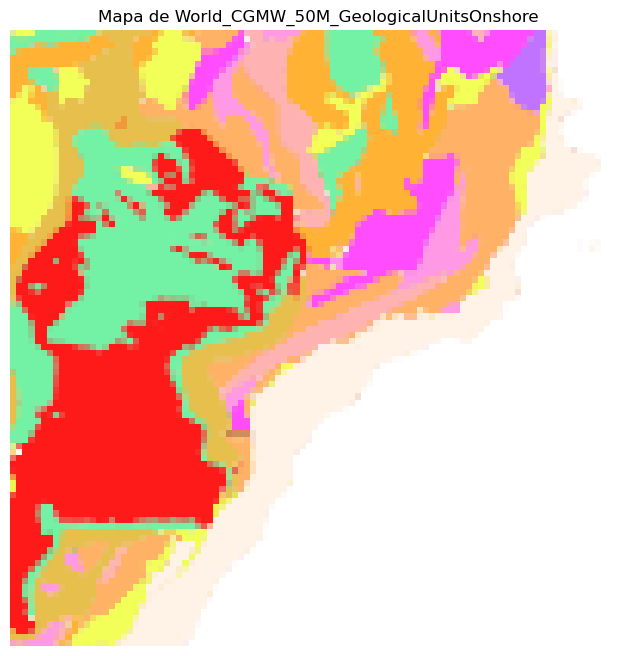

Coordenadas: Latitude -23.5505, Longitude -46.6333
Pixel: (50, 99)
Cor RGBA: (0, 0, 0, 0)


In [8]:
# Fazer a solicitação GET ao serviço WMS
response = requests.get(WMS_URL, params=params)

# Verificar se a solicitação foi bem-sucedida
if response.status_code == 200:
    # Abrir a imagem usando Pillow
    image = Image.open(BytesIO(response.content)).convert("RGBA")
    
    # Exibir a imagem no Jupyter Notebook usando matplotlib
    plt.figure(figsize=(8, 8))
    plt.imshow(image)
    plt.title(f"Mapa de {LAYERS}")
    plt.axis('off')  # Ocultar eixos
    plt.show()
    
    # Calcular a posição do pixel correspondente à latitude e longitude
    # Para WMS 1.3.0 com CRS=EPSG:4326, a ordem é [min_lat, min_lon, max_lat, max_lon]
    y_fraction = (bbox[3] - latitude) / (bbox[3] - bbox[0])  # Inverter Y porque as imagens começam do topo
    x_fraction = (longitude - bbox[1]) / (bbox[3] - bbox[1])
    
    pixel_x = int(x_fraction * WIDTH)
    pixel_y = int(y_fraction * HEIGHT)
    
    # Garantir que os valores dos pixels estejam dentro dos limites da imagem
    pixel_x = max(0, min(WIDTH - 1, pixel_x))
    pixel_y = max(0, min(HEIGHT - 1, pixel_y))
    
    # Obter a cor do pixel
    pixel_color = image.getpixel((pixel_x, pixel_y))
    
    print(f"Coordenadas: Latitude {latitude}, Longitude {longitude}")
    print(f"Pixel: ({pixel_x}, {pixel_y})")
    print(f"Cor RGBA: {pixel_color}")
else:
    print(f"Erro na solicitação WMS: {response.status_code}")
    # Opcional: Exibir o conteúdo da resposta para depuração
    print(response.text)

In [1]:
import rasterio
from rasterio.transform import from_origin
import numpy as np

def obter_cor(mapa_path, latitude, longitude):
    """
    Obtém a cor (RGB) no ponto especificado por latitude e longitude.

    :param mapa_path: Caminho para o arquivo raster (mapa.tif)
    :param latitude: Latitude do ponto
    :param longitude: Longitude do ponto
    :return: Tuple contendo (R, G, B) ou None se o ponto estiver fora do raster
    """
    with rasterio.open(mapa_path) as src:
        # Verifica se o CRS é geográfico (WGS84)
        if src.crs.to_string() != 'EPSG:4326':
            raise ValueError("O CRS do raster não é EPSG:4326 (WGS84).")

        # Transforma as coordenadas geográficas para coordenadas de pixel
        try:
            px, py = src.index(longitude, latitude)
        except ValueError:
            print("As coordenadas fornecidas estão fora do raster.")
            return None

        # Verifica se os pixels estão dentro dos limites
        if (px < 0 or px >= src.width) or (py < 0 or py >= src.height):
            print("As coordenadas fornecidas estão fora do raster.")
            return None

        # Supondo que o raster tem 3 bandas (RGB)
        bandas = src.read([1, 2, 3])  # Lê as bandas R, G e B

        # Obtém os valores das bandas no pixel específico
        R = bandas[0, py, px]
        G = bandas[1, py, px]
        B = bandas[2, py, px]

        return (R, G, B)

In [ ]:
import pandas as pd

data = {
  "Cor": ["f2ff59", "73f2a6", "e6bf4c", "bf8040", "ffb233", "ffb2b2", "ff99e6", "99e633", "66d933", "d98c33", "bf73ff", "ff738c", "ff9980", "e6a6ff", "ff8cb2", "ffb2d9", "ff73cc", "1ac1ff", "e6bf4c", "bf8040", "ffb266", "ffb2b2", "ff99e6", "d9d966", "99e633", "66d933", "ffbf40", "ff9980", "ffb2d9", "bf73ff", "f2ff59", "73f2a6", "e6bf4c", "bf8040", "ffb266", "ffb2b2", "ff99e6", "d9d966", "99e633", "66d933", "d98c33", "ffbf40", "f273a6", "ff9980", "ffb2d9", "ff73cc", "f259f8", "bf73ff", "c0bebd", "f259f8", "d9d9f2", "d9d9f2", "99e6e6", "fd2b1b", "26ff80", "fff2e6"],
  "Tipo de Crosta": ["Continental", "Continental", "Continental", "Continental", "Continental", "Continental", "Continental", "Continental", "Continental", "Continental", "Continental", "Continental", "Continental", "Continental", "Continental", "Continental", "Continental", "Continental", "Continental", "Continental", "Continental", "Continental", "Continental", "Continental", "Continental", "Continental", "Continental", "Continental", "Continental", "Continental", "Continental", "Continental", "Continental", "Continental", "Continental", "Continental", "Continental", "Continental", "Continental", "Continental", "Continental", "Continental", "Continental", "Continental", "Continental", "Continental", "Continental", "Continental", "Continental", "Continental", "Glacial", "Subglacial", "Extensão", "Igneosa", "Ophiolítica", "Continental ou Insular"],
  "Tipo de Rocha": ["Rochas sedimentares ou facies indiferenciadas", "Rochas sedimentares ou facies indiferenciadas", "Rochas sedimentares ou facies indiferenciadas", "Rochas sedimentares ou facies indiferenciadas", "Rochas sedimentares ou facies indiferenciadas", "Rochas sedimentares ou facies indiferenciadas", "Rochas sedimentares ou facies indiferenciadas", "Rochas sedimentares ou facies indiferenciadas", "Rochas sedimentares ou facies indiferenciadas", "Rochas sedimentares ou facies indiferenciadas", "Rochas sedimentares ou facies indiferenciadas", "Rochas sedimentares ou facies indiferenciadas", "Rochas sedimentares ou facies indiferenciadas", "Rochas sedimentares ou facies indiferenciadas", "Rochas sedimentares ou facies indiferenciadas", "Rochas sedimentares ou facies indiferenciadas", "Rochas sedimentares ou facies indiferenciadas", "Rochas vulcânicas extrusivas (exceção traps)", "Rochas vulcânicas extrusivas (exceção traps)", "Rochas vulcânicas extrusivas (exceção traps)", "Rochas vulcânicas extrusivas (exceção traps)", "Rochas vulcânicas extrusivas (exceção traps)", "Rochas vulcânicas extrusivas (exceção traps)", "Rochas vulcânicas extrusivas (exceção traps)", "Rochas vulcânicas extrusivas (exceção traps)", "Rochas vulcânicas extrusivas (exceção traps)", "Rochas vulcânicas extrusivas (exceção traps)", "Rochas vulcânicas extrusivas (exceção traps)", "Rochas vulcânicas extrusivas (exceção traps)", "Rochas vulcânicas extrusivas (exceção traps)", "Rochas endógenas (plutônicas e/ou metamórficas)", "Rochas endógenas (plutônicas e/ou metamórficas)", "Rochas endógenas (plutônicas e/ou metamórficas)", "Rochas endógenas (plutônicas e/ou metamórficas)", "Rochas endógenas (plutônicas e/ou metamórficas)", "Rochas endógenas (plutônicas e/ou metamórficas)", "Rochas endógenas (plutônicas e/ou metamórficas)", "Rochas endógenas (plutônicas e/ou metamórficas)", "Rochas endógenas (plutônicas e/ou metamórficas)", "Rochas endógenas (plutônicas e/ou metamórficas)", "Rochas endógenas (plutônicas e/ou metamórficas)", "Rochas endógenas (plutônicas e/ou metamórficas)", "Rochas endógenas (plutônicas e/ou metamórficas)", "Rochas endógenas (plutônicas e/ou metamórficas)", "Rochas endógenas (plutônicas e/ou metamórficas)", "Rochas endógenas (plutônicas e/ou metamórficas)", "Rochas endógenas (plutônicas e/ou metamórficas)", "Rochas endógenas (plutônicas e/ou metamórficas)", "Rochas endógenas (plutônicas e/ou metamórficas)", "Facies indiferenciadas", "Geada interna, Gelo", "Rochas subglaciais, Localizadas abaixo do nível do mar (cobertura de gelo da Antártida e Groenlândia)", "Plataforma de gelo (Antártida)", "Província Igneosa (LIP): Traps com indicação de idade média em Ma", "Complexo Mesozoolítico-Cenozoico, Idade", "Plataforma continental (profundidade menor que 200 m), Exceto Antártida"],
  "Idade Geológica": ["Cenozoico", "Mesozoico", "Paleozóico Superior", "Paleozóico Inferior", "Neoproterozoico", "Mesoproterozoico", "Paleoproterozoico", "Mesozoico a Paleozóico Superior", "Mesozoico a Paleozóico", "Paleozóico", "Paleoproterozoico a Arqueano", "Paleozóico a Pré-Cambriano", "Neoproterozoico a Paleozóico Inferior", "Mesoproterozoico a Paleoproterozoico", "Neoproterozoico a Mesoproterozoico", "Proterozoico", "Pré-Cambriano", "Cenozoico", "Paleozóico Superior", "Paleozóico Inferior", "Neoproterozoico", "Mesoproterozoico", "Paleoproterozoico", "Cenozoico a Mesozoico", "Mesozoico a Paleozóico Superior", "Mesozoico a Paleozóico", "Paleozóico a Neoproterozoico", "Paleozóico Inferior a Neoproterozoico", "Proterozoico", "Paleoproterozoico a Arqueano", "Cenozoico", "Mesozoico", "Paleozóico Superior", "Paleozóico Inferior", "Neoproterozoico", "Mesoproterozoico", "Paleoproterozoico", "Cenozoico a Mesozoico", "Mesozoico a Paleozóico Superior", "Mesozoico a Paleozóico", "Paleozóico", "Paleozóico a Neoproterozoico", "Paleozóico a Paleoproterozoico", "Paleozóico Inferior a Neoproterozoico", "Proterozoico", "Pré-Cambriano", "Mesoproterozoico a Arqueano", "Paleoproterozoico a Arqueano", "Idade desconhecida", "Arqueano", "-", "-", "-", "-", "-", "-"]
}

df = pd.DataFrame(data)

In [1]:
mapa_caminho = './mapa/mapa.tif'  # Atualize para o caminho correto
latitude = -23.5505    # Exemplo: Latitude de São Paulo
longitude = -46.6333   # Exemplo: Longitude de São Paulo

cor = obter_cor(mapa_caminho, latitude, longitude)
if cor:
	print(f"A cor no ponto ({latitude}, {longitude}) é RGB: {cor}")
else:
	print("Não foi possível obter a cor no ponto especificado.")

NameError: name 'obter_cor' is not defined

In [2]:
import geopandas as gpd
from scipy.spatial import KDTree
import pandas as pd

# Carrega o arquivo GeoJSON
gdf = gpd.read_file('simplified_cities.geojson')

# Garante que o CRS esteja definido como WGS84
gdf.set_crs(epsg=4326, inplace=True)

# Extrai as coordenadas (longitude, latitude) e converte para radianos
coords = list(zip(gdf.geometry.x, gdf.geometry.y))

# Constrói o KD-Tree
tree = KDTree(coords)

point = (longitude, latitude)  # KDTree espera (x, y) = (longitude, latitude)

# Consulta o vizinho mais próximo
distance, index = tree.query(point)

nearest_city = gdf.iloc[index]
nearest_city

id                          node/30674098
name                            São Paulo
geometry    POINT (-46.633382 -23.550651)
Name: 3654, dtype: object